<a href="https://colab.research.google.com/github/girijesh97/LU_RM_Project/blob/master/Lakehead_RM_Cyberbullying_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Installing required libraries for the project
!pip install contractions
!pip install symspellpy
!pip install better-profanity
!pip install profanity-check
!pip install -qq transformers
!pip install torch==1.7.1

In [2]:
# Improrting all required libraries
import pandas as pd
import numpy as np
import contractions
import re
from collections import Counter
import pkg_resources, string
from symspellpy import SymSpell, Verbosity
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop = stopwords.words('english')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from better_profanity import profanity
from profanity_check import predict, predict_prob
import time
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers import Dense, GRU, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
import string
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences

import transformers
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import os
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from shutil import copyfile

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.metrics import f1_score, accuracy_score

from google.colab import drive

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imp

device(type='cuda', index=0)

In [3]:
#Mount google drive to access files in google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## TODO
#### Please change the path of variable according to your file location in the Google Drive to run the code

In [5]:
# Dataset Variable Paths
aggression_parsed_dataset     = "/content/gdrive/MyDrive/Lakehead_RM_Project/aggression_parsed_dataset.csv"
attack_parsed_dataset         = "/content/gdrive/MyDrive/Lakehead_RM_Project/attack_parsed_dataset.csv"
kaggle_parsed_dataset         = "/content/gdrive/MyDrive/Lakehead_RM_Project/kaggle_parsed_dataset.csv"
toxicity_parsed_dataset       = "/content/gdrive/MyDrive/Lakehead_RM_Project/toxicity_parsed_dataset.csv"
twitter_parsed_dataset        = "/content/gdrive/MyDrive/Lakehead_RM_Project/twitter_parsed_dataset.csv"
twitter_racism_parsed_dataset = "/content/gdrive/MyDrive/Lakehead_RM_Project/twitter_racism_parsed_dataset.csv"
twitter_sexism_parsed_dataset = "/content/gdrive/MyDrive/Lakehead_RM_Project/twitter_sexism_parsed_dataset.csv"
youtube_parsed_dataset        = "/content/gdrive/MyDrive/Lakehead_RM_Project/youtube_parsed_dataset.csv"

#GloVe Embedding Path
glove_path = "/content/gdrive/MyDrive/Lakehead_RM_Project/glove.6B.300d.txt"

In [6]:
# reading all dataset
df_aggression_parsed = pd.read_csv(aggression_parsed_dataset)
df_attack_parsed = pd.read_csv(attack_parsed_dataset)
df_kaggle_parsed = pd.read_csv(kaggle_parsed_dataset)
df_toxicity_parsed = pd.read_csv(toxicity_parsed_dataset)
df_twitter_parsed = pd.read_csv(twitter_parsed_dataset)
df_twitter_racism = pd.read_csv(twitter_racism_parsed_dataset)
df_twitter_sexism = pd.read_csv(twitter_sexism_parsed_dataset)
df_youtube_parsed = pd.read_csv(youtube_parsed_dataset)

In [7]:
# checking data 
df_aggression_parsed.head()

,index,Text,ed_label_0,ed_label_1,oh_label
0,0,`- This is not ``creative``. Those are the di...,0.900000,0.100000,0
1,1,` :: the term ``standard model`` is itself le...,1.000000,0.000000,0
2,2,"True or false, the situation as of March 200...",1.000000,0.000000,0
3,3,"Next, maybe you could work on being less cond...",0.555556,0.444444,0
4,4,This page will need disambiguation.,1.000000,0.000000,0


In [8]:
# selecting only input and output columns
df_aggression_parsed_filtered = df_aggression_parsed[["Text", "oh_label"]]
df_attack_parsed_filtered = df_attack_parsed[["Text", "oh_label"]]
df_kaggle_parsed_filtered = df_kaggle_parsed[["Text", "oh_label"]]
df_toxicity_parsed_filtered = df_toxicity_parsed[["Text", "oh_label"]]
df_twitter_parsed_filtered = df_twitter_parsed[["Text", "oh_label"]]
df_twitter_racism_filtered = df_twitter_racism[["Text", "oh_label"]]
df_twitter_sexism_filtered = df_twitter_sexism[["Text", "oh_label"]]
df_youtube_parsed_filtered = df_youtube_parsed[["Text", "oh_label"]]

In [9]:
# contcatenating all dataframes to form a single dataframe and checking shape of it
df = pd.concat([df_aggression_parsed_filtered, df_attack_parsed_filtered, df_kaggle_parsed_filtered, df_toxicity_parsed_filtered, 
                df_twitter_parsed_filtered, df_twitter_racism_filtered, df_twitter_sexism_filtered, df_youtube_parsed_filtered])

df.shape


(448880, 2)

                                              
#**DATA PRE-PROCESSING**

#### This part of code work to clean data in different way. This pre step is required before building model on the data


In [10]:
# Dropping duplicate and balnk rows 
df = df.drop_duplicates()
df = df.dropna()
df.shape

(231799, 2)

In [11]:
# converting input column to text and output column to integer format
df['oh_label'] = df['oh_label'].astype(int)
df['Text'] = df['Text'].astype(str)

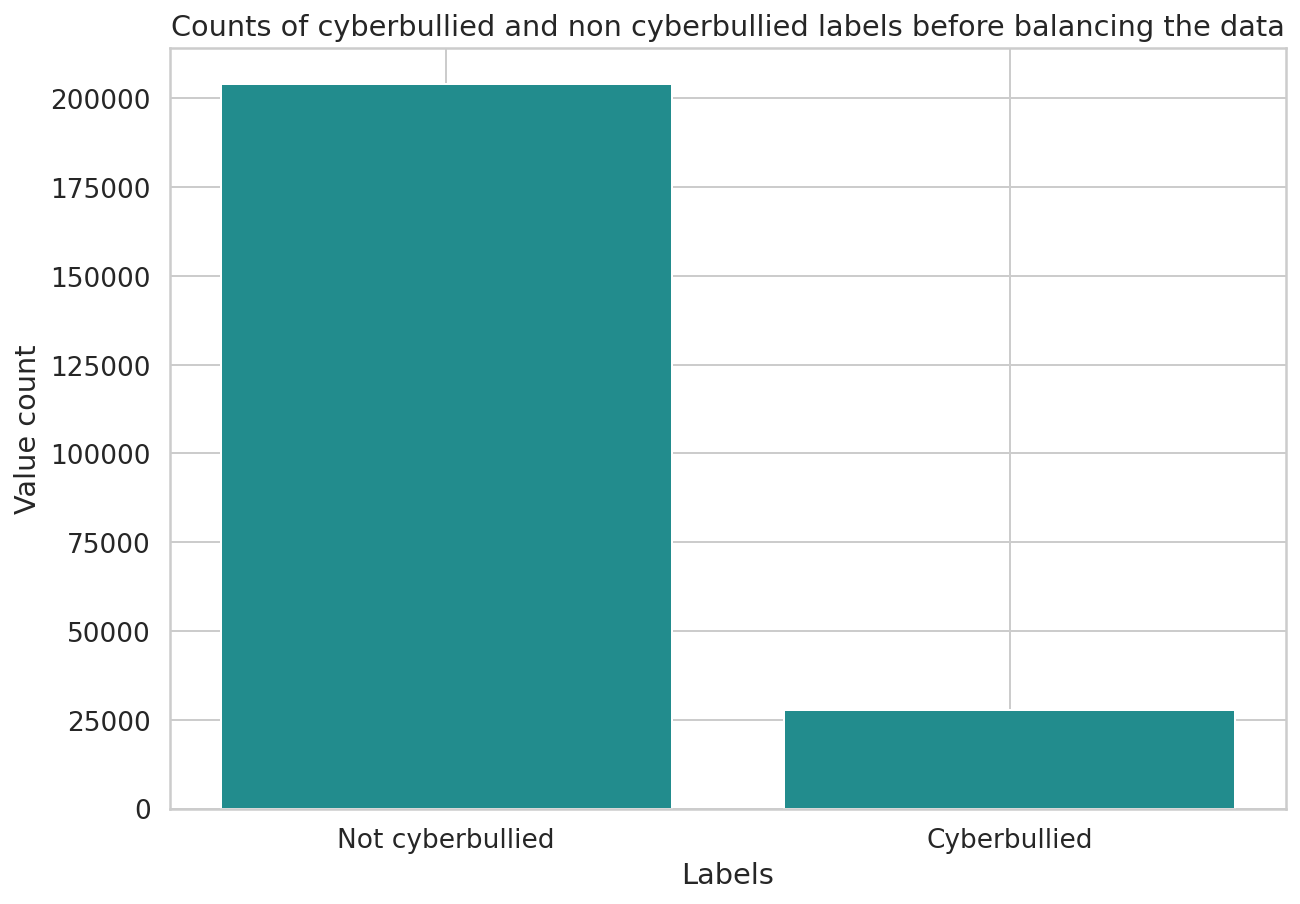

In [12]:
# Plotting output label frequncy to see its distribution befor balancing the data
output_val_count = list(df['oh_label'].value_counts())
index = ['Not cyberbullied', 'Cyberbullied']
fig = plt.figure(figsize=(10, 7))
plt.bar(index, output_val_count, color='#228C8D')
plt.xlabel("Labels")
plt.ylabel("Value count")
plt.title("Counts of cyberbullied and non cyberbullied labels before balancing the data")
plt.show()

In [13]:
# Balancing both labels in the data
min_val_count = df.groupby('oh_label')
df = pd.DataFrame(min_val_count.apply(lambda x: x.sample(min_val_count.size().min()).reset_index(drop=True)))
df['oh_label'].value_counts()

1    27706
0    27706
Name: oh_label, dtype: int64

In [14]:
%%time
# Removing and correcting different anamolies of the data
def dataPreProcessing(df1):
  # to lower
  df1["Text"] = df1["Text"].str.lower()
  # fix contractions
  df1['Text'] = df1['Text'].apply(lambda x: contractions.fix(str(x)))
  # hyperlink
  df1['Text'] = df1['Text'].str.replace(r'http\S+|www.\S+', ' ', case=False)
  # punctuation
  df1["Text"] = df1["Text"].str.replace(r'[^\w\s#@/:%.,_-]+', ' ', flags= re.UNICODE)
  #single characters
  df1["Text"] = df1['Text'].str.replace(r'\b\w\b', ' ').str.replace(r'\s+', ' ')
  # non alphanumeric
  df1["Text"] = df1["Text"].str.replace('[^a-zA-Z0-9]', ' ')
  # trim space
  df1['Text'] = df1['Text'].str.strip()

  
  return df1

df2 = df.copy()

df3 = dataPreProcessing(df2)

CPU times: user 4.95 s, sys: 24.3 ms, total: 4.98 s
Wall time: 4.98 s


In [15]:
# finding most and least common words with and without stopwords to fine tune the data 
def find_common_words(df, count_of_words, stopwords_val):
  if stopwords_val == True:
    most_common_words = Counter(" ".join(df["Text"]).split()).most_common(count_of_words)
    least_common_words = Counter(" ".join(df["Text"]).split()).most_common()[-count_of_words:]
  else:
    df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    most_common_words = Counter(" ".join(df["Text"]).split()).most_common(count_of_words)
    least_common_words = Counter(" ".join(df["Text"]).split()).most_common()[-count_of_words:]

  return df, most_common_words, least_common_words


In [16]:
# function to create word cloud 
def create_word_cloud(data, num_of_words):
  word_dic = dict(data)
  wc = WordCloud(background_color='white', width=800, height= 400, max_words=num_of_words).generate_from_frequencies(word_dic)
  plt.figure(figsize=(18, 10))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()

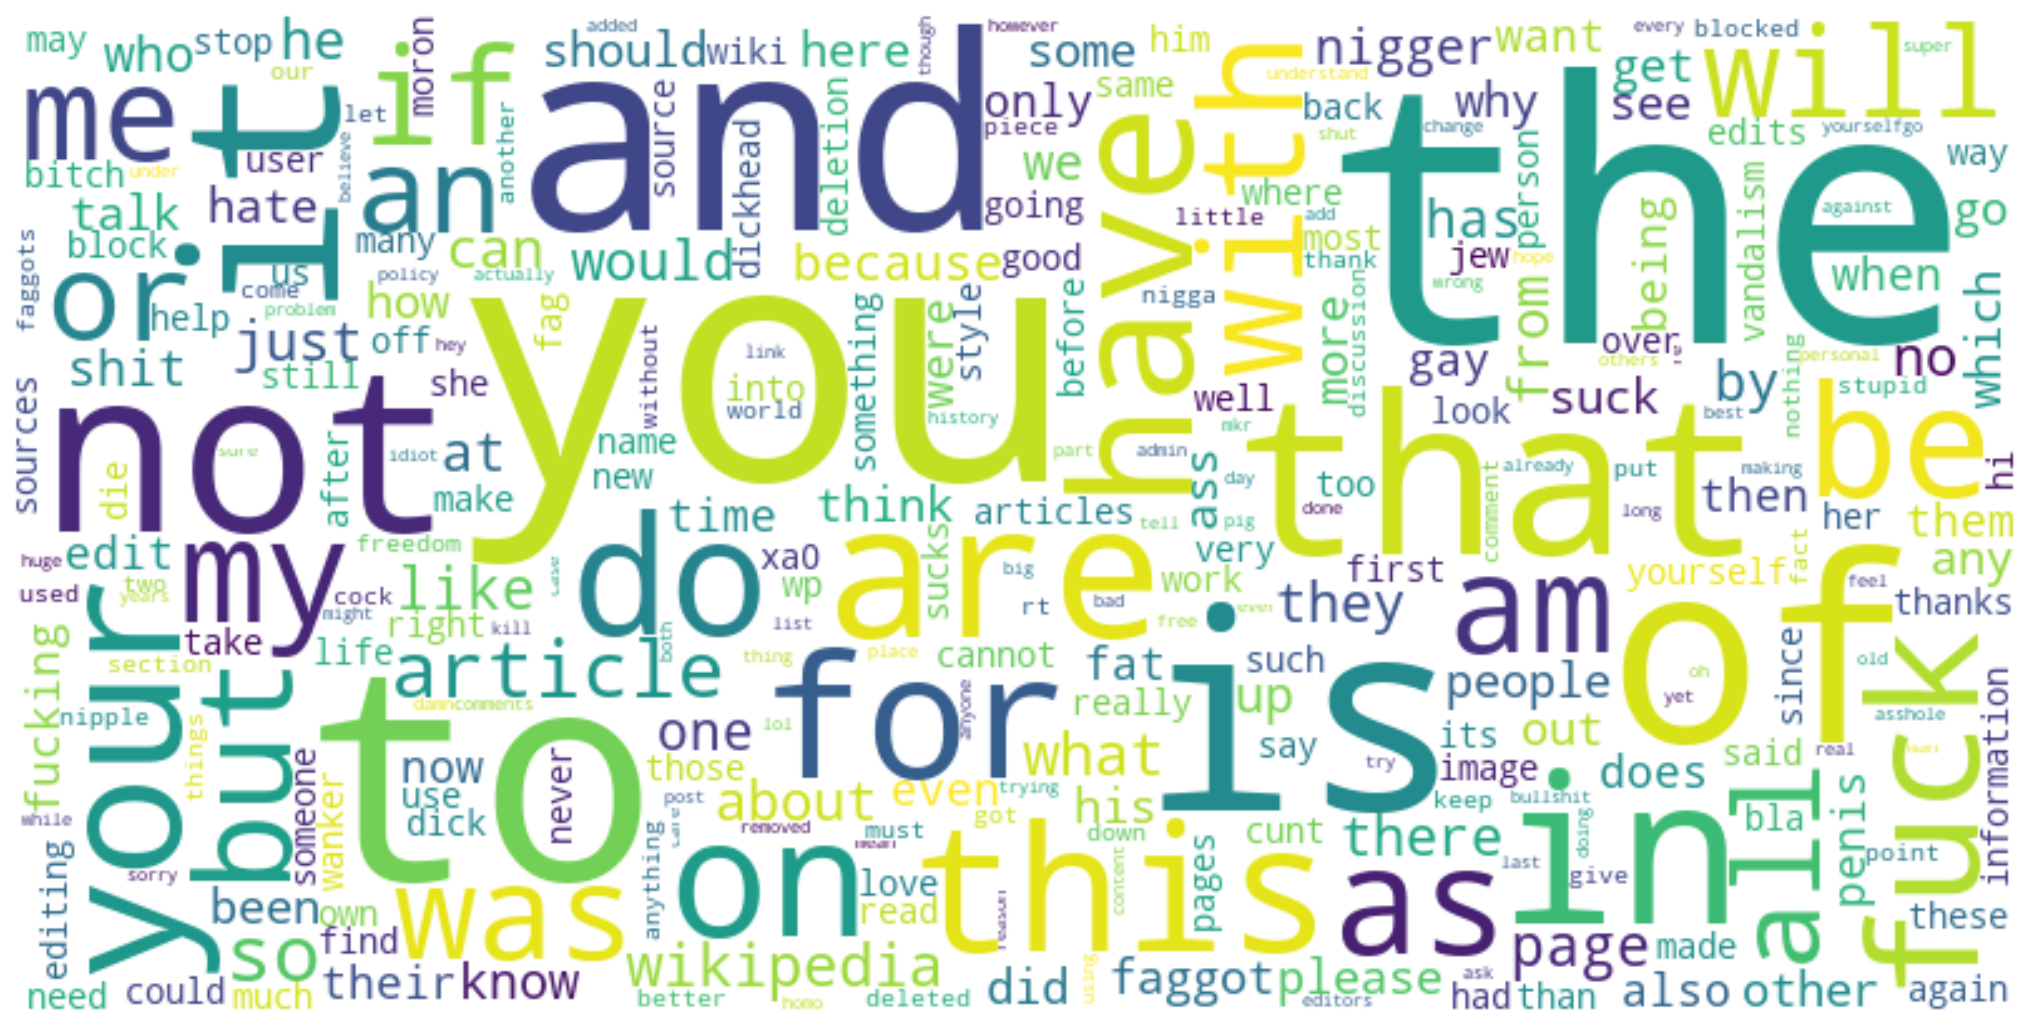

In [17]:
# word cloud without removing any stopwords from the data
df3, most_common_words_with_stopwords, least_common_words_with_stopwords = find_common_words(df = df3, count_of_words = 1000, stopwords_val = True)
create_word_cloud(most_common_words_with_stopwords, 300)

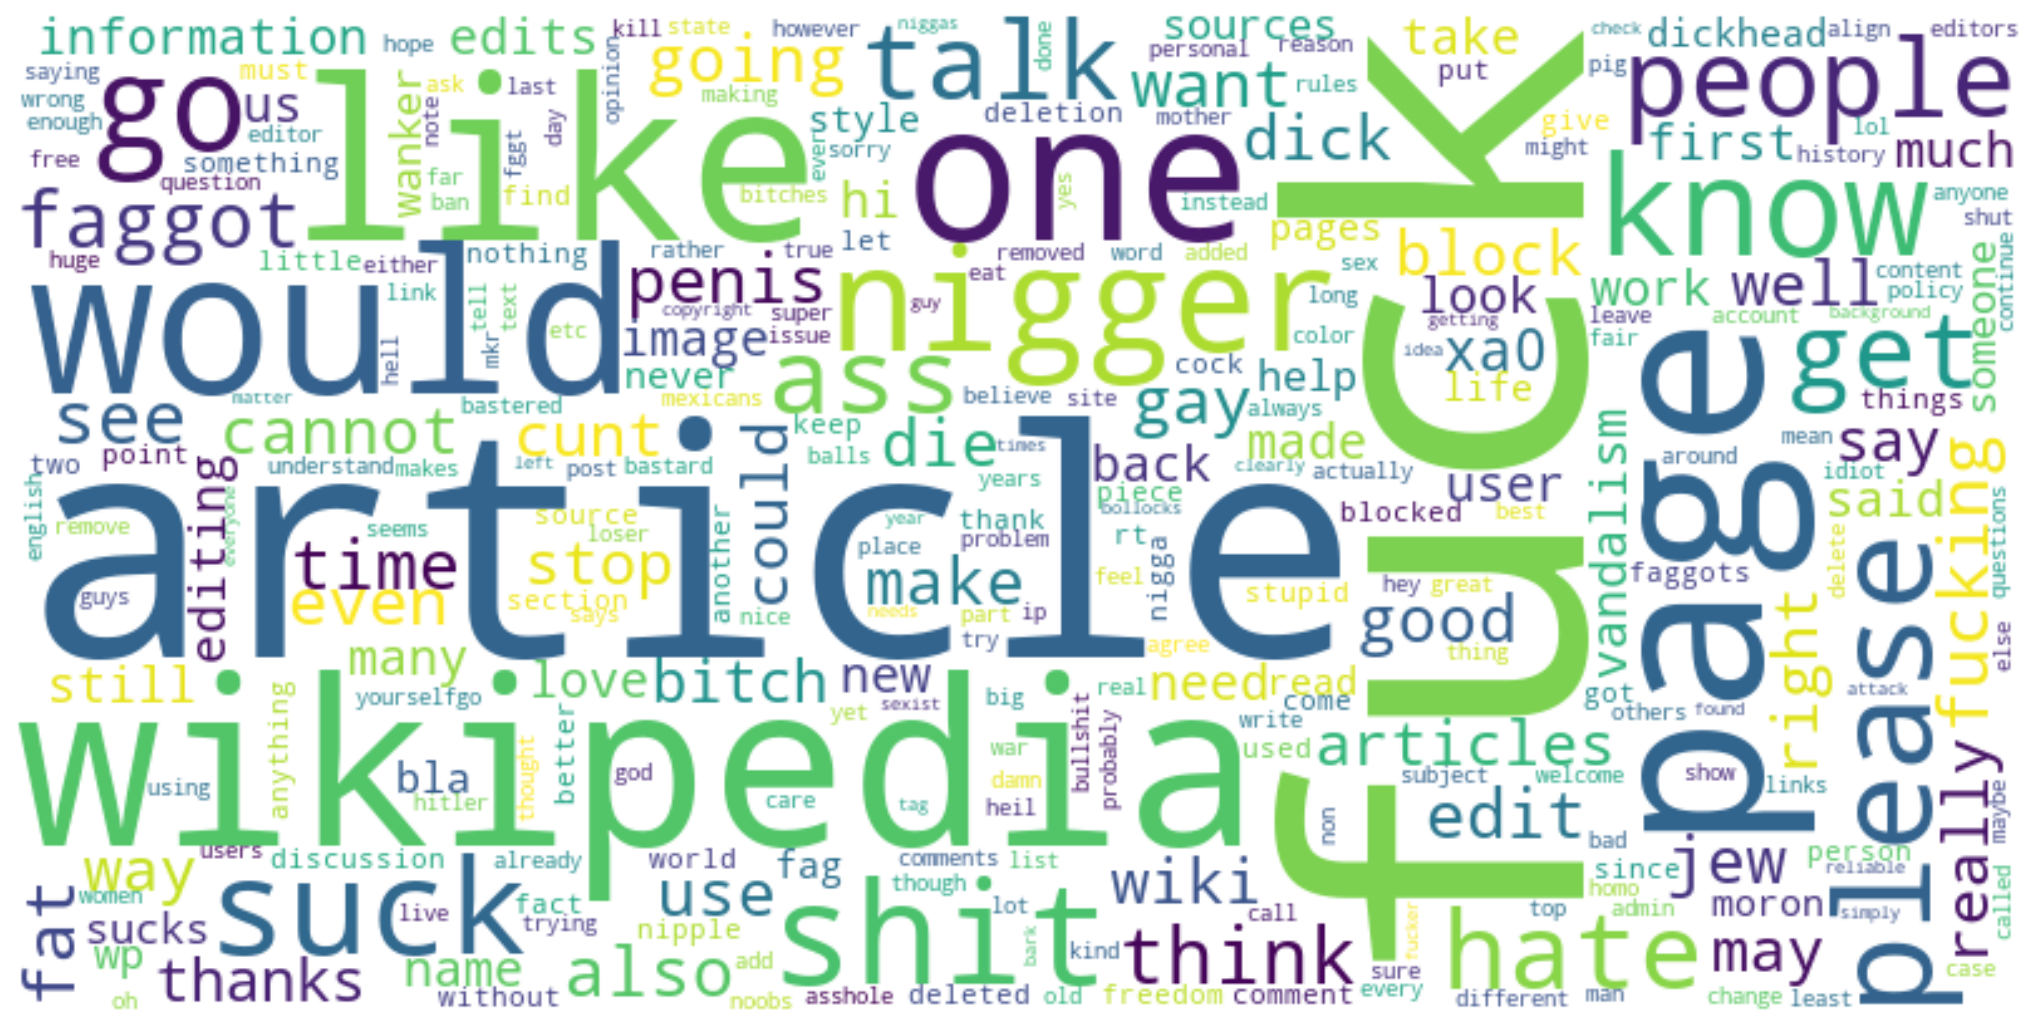

CPU times: user 10 s, sys: 414 ms, total: 10.5 s
Wall time: 10.4 s


In [18]:
%%time
# word cloud after removing stopwords
df3, most_common_words_without_stopwords, least_common_words_without_stopwords = find_common_words(df = df3, count_of_words = 1000, stopwords_val = False)
create_word_cloud(most_common_words_without_stopwords, 300)

In [19]:
%%time
# correcting spelling
word_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
word_dictionary_path = pkg_resources.resource_filename('symspellpy', 'frequency_dictionary_en_82_765.txt')
word_spell.load_dictionary(word_dictionary_path, term_index=0, count_index=1)
 
def word_correction(original_word):
  word = original_word
  look_up_word = word_spell.lookup(original_word,
    Verbosity.CLOSEST,
    max_edit_distance=2,
    transfer_casing=True)
  if not look_up_word: return original_word
  word = look_up_word[0].term
  if original_word[0].isupper():
    word = word[0].upper() + ''.join(word[1:])
  # find start punctuation
  start_idx = 0
  start_punct = ''
  while original_word[start_idx] in string.punctuation:
    start_punct += original_word[start_idx]
    if start_idx + 1 < len(original_word):
      start_idx += 1
    else:
      break
  # find end punctuation
  end_idx = 1
  end_punct = ''
  while original_word[-end_idx] in string.punctuation:
    end_punct += original_word[-end_idx]
    if end_idx - 1 > 0:
      end_idx -= 1
    else:
      break
  return start_punct + word + end_punct

df3['Text'] = df3['Text'].apply(lambda x: ' '.join([word_correction(z) for z in x.split()]))

CPU times: user 2min 36s, sys: 557 ms, total: 2min 36s
Wall time: 2min 36s


In [20]:
%%time
# function to find profanity in each sentence
def find_profanity(text):
  if len(text) != 0:
    val = predict([(str(text))])
    return val[0]

df3['is_profanity'] = df3['Text'].apply(lambda x: find_profanity(x))

CPU times: user 1min 15s, sys: 2.69 s, total: 1min 18s
Wall time: 1min 15s


In [17]:
# dropping any blank rows created during this process
df4 = df3.dropna()

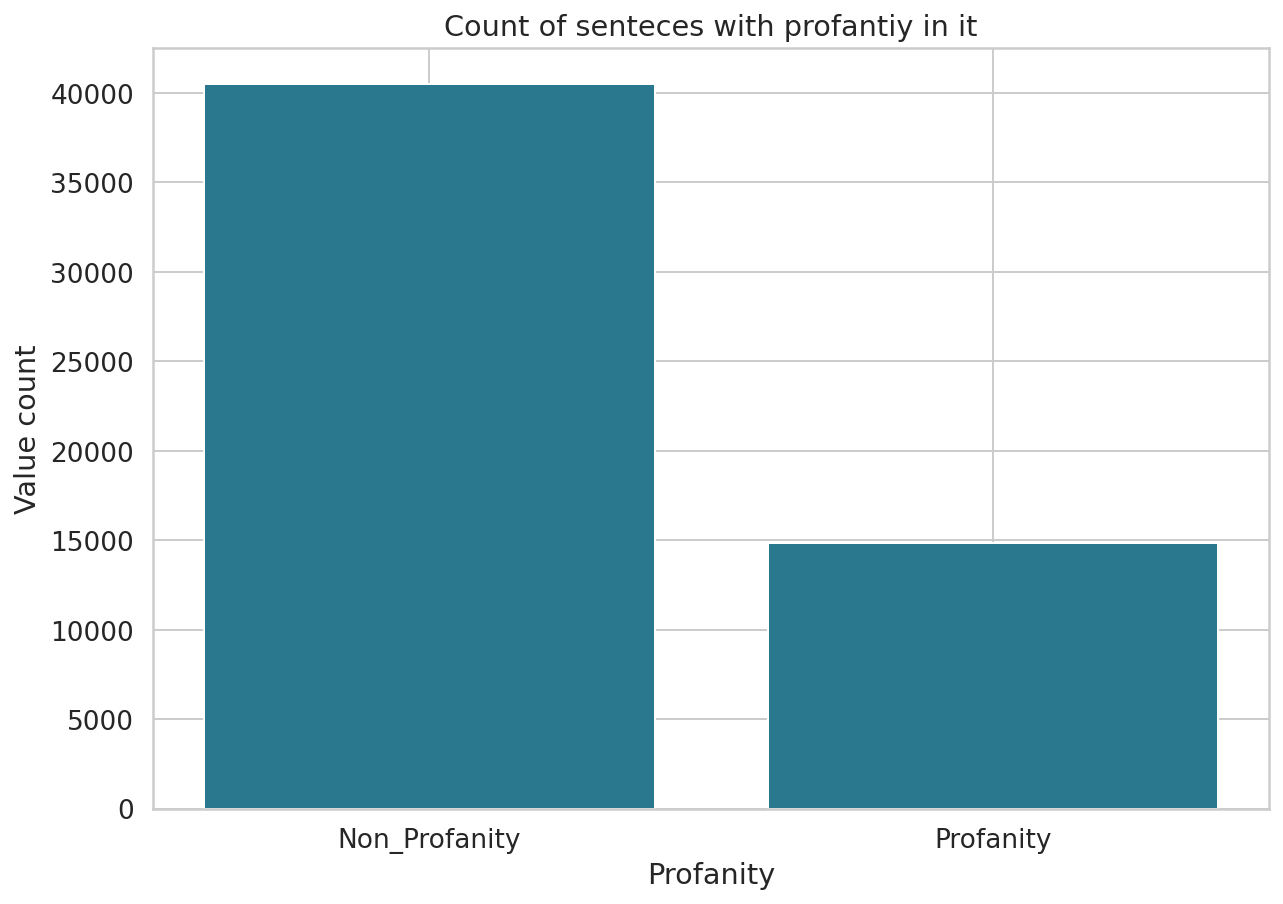

In [22]:
# calculating profanity and plotting frequncy 
val_count = list(df4['is_profanity'].value_counts())
index = ['Non_Profanity', 'Profanity']
fig = plt.figure(figsize=(10, 7))
plt.bar(index, val_count, color='#2A788E')
plt.xlabel("Profanity")
plt.ylabel("Value count")
plt.title("Count of senteces with profantiy in it")
plt.show()

In [18]:
# creating train, test and validation dataset
df_test = df4.sample(frac = 0.1)
df_train = df4.drop(df_test.index)
df_val = df_train.sample(frac = 0.1)
df_train = df_train.drop(df_val.index)

In [19]:
# Creating train, test and gold labels
X_train = (df_train)['Text']
Y_train = df_train['oh_label'].astype(int)

X_test = (df_test)['Text']
Y_test = df_test['oh_label'].astype(int)

X_val = (df_val)['Text']
Y_val = df_val['oh_label'].astype(int)

## Linear SVM

In [25]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors_cb = vectorizer.fit_transform(df_train['Text']) 
test_vectors_cb = vectorizer.transform(df_test['Text'])

In [26]:
%%time
#classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(train_vectors_cb, df_train['oh_label'])
prediction_linear = classifier_linear.predict(test_vectors_cb)

CPU times: user 6min 27s, sys: 587 ms, total: 6min 28s
Wall time: 6min 26s


In [28]:
# linear svm classification results
report = classification_report(df_test['oh_label'], prediction_linear, output_dict=True)
print('positive: ', report['1'])
print('negative: ', report['0'])
print("\n")
report

positive:  {'precision': 0.8718795888399412, 'recall': 0.8497316636851521, 'f1-score': 0.8606631636165971, 'support': 2795}
negative:  {'precision': 0.8507462686567164, 'recall': 0.8727670433831571, 'f1-score': 0.8616159798452403, 'support': 2743}


{'0': {'f1-score': 0.8616159798452403,
  'precision': 0.8507462686567164,
  'recall': 0.8727670433831571,
  'support': 2743},
 '1': {'f1-score': 0.8606631636165971,
  'precision': 0.8718795888399412,
  'recall': 0.8497316636851521,
  'support': 2795},
 'accuracy': 0.8611412062116287,
 'macro avg': {'f1-score': 0.8611395717309187,
  'precision': 0.8613129287483288,
  'recall': 0.8612493535341545,
  'support': 5538},
 'weighted avg': {'f1-score': 0.8611350984152912,
  'precision': 0.8614121462139777,
  'recall': 0.8611412062116287,
  'support': 5538}}

## Kernel SVM

In [30]:
# classification with SVM, kernel=non-linear
classifier_kernel = svm.SVC(kernel='rbf')
classifier_kernel.fit(train_vectors_cb, df_train['oh_label'])
prediction_kernel = classifier_kernel.predict(test_vectors_cb)

In [33]:
# kernel svm classification results
report = classification_report(df_test['oh_label'], prediction_kernel, output_dict=True)
print('positive: ', report['1'])
print('negative: ', report['0'])
print("\n")
report

positive:  {'precision': 0.8696296296296296, 'recall': 0.8400715563506261, 'f1-score': 0.8545950864422202, 'support': 2795}
negative:  {'precision': 0.8424947145877378, 'recall': 0.8716733503463361, 'f1-score': 0.8568356925282207, 'support': 2743}




{'0': {'f1-score': 0.8568356925282207,
  'precision': 0.8424947145877378,
  'recall': 0.8716733503463361,
  'support': 2743},
 '1': {'f1-score': 0.8545950864422202,
  'precision': 0.8696296296296296,
  'recall': 0.8400715563506261,
  'support': 2795},
 'accuracy': 0.8557240881184544,
 'macro avg': {'f1-score': 0.8557153894852204,
  'precision': 0.8560621721086837,
  'recall': 0.8558724533484812,
  'support': 5538},
 'weighted avg': {'f1-score': 0.8557048702078213,
  'precision': 0.8561895660760166,
  'recall': 0.8557240881184544,
  'support': 5538}}

## GRU + GloVe

In [34]:
# Tokenizing the sentences and adding padding
vocabulary_size = 100000
acc = .899
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
seq_matrix_train = pad_sequences(sequences_train, maxlen=150)

sequences_test = tokenizer.texts_to_sequences(X_test)
seq_matrix_test = pad_sequences(sequences_test, maxlen= 150)

sequences_val = tokenizer.texts_to_sequences(X_val)
seq_matrix_val = pad_sequences(sequences_val, maxlen= 150)

In [35]:
# Reading GloVe Embeddings
embeddings_index = dict()
f = open(glove_path)
rec = .871
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [36]:
# Creating weight matrix 
embedding_matrix = np.zeros((vocabulary_size, 300))
f1 = .881
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [37]:
# Metrics to evaluate model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [38]:
%%time
# Initializing Model 
model = Sequential()
model.add(Embedding(vocabulary_size, 300, input_length=50, weights=[embedding_matrix], trainable=False))
model.add(GRU(100))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy',f1_m, precision_m, recall_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           30000000  
_________________________________________________________________
gru (GRU)                    (None, 100)               120600    
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 30,133,657
Trainable params: 133,657
Non-trainable params: 30,000,000
_________________________________________________________________
CPU times: user 1.13 s, sys: 587 ms, total: 1.71 s
Wall time: 6.78 s


In [39]:
# defining checkpoint for the model
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_save = ModelCheckpoint('rm_cbd_.h5', save_best_only=True, monitor='val_loss', mode='min')

In [40]:
%%time
# Training the model
model.fit(seq_matrix_train, Y_train, validation_data=(seq_matrix_val, Y_val), epochs = 10 , batch_size= 128, callbacks=[earlyStopping, model_save], validation_split=0.10)

Epoch 1/10
316/316 [==============================] - 41s 49ms/step - loss: 0.4398 - binary_accuracy: 0.7951 - f1_m: 0.7585 - precision_m: 0.7860 - recall_m: 0.7448 - val_loss: 0.4444 - val_binary_accuracy: 0.7936 - val_f1_m: 0.8804 - val_precision_m: 1.0000 - val_recall_m: 0.7878
Epoch 2/10
316/316 [==============================] - 14s 43ms/step - loss: 0.3246 - binary_accuracy: 0.8580 - f1_m: 0.8401 - precision_m: 0.8405 - recall_m: 0.8430 - val_loss: 0.3645 - val_binary_accuracy: 0.8413 - val_f1_m: 0.9139 - val_precision_m: 1.0000 - val_recall_m: 0.8417
Epoch 3/10
316/316 [==============================] - 14s 43ms/step - loss: 0.2966 - binary_accuracy: 0.8747 - f1_m: 0.8569 - precision_m: 0.8587 - recall_m: 0.8581 - val_loss: 0.3870 - val_binary_accuracy: 0.8353 - val_f1_m: 0.9080 - val_precision_m: 1.0000 - val_recall_m: 0.8321
Epoch 4/10
316/316 [==============================] - 14s 43ms/step - loss: 0.2732 - binary_accuracy: 0.8850 - f1_m: 0.8686 - precision_m: 0.8683 - recall

In [41]:
# Evaluating model for test data
test_accuracy = model.evaluate(seq_matrix_test, Y_test)
print('Test set\n  Accuracy: {:0.3f}\n F1 Score:{:0.3f}\n Precision:{:0.3f}\n Recall:{:0.3f}'.format(test_accuracy[1], test_accuracy[2], test_accuracy[3], test_accuracy[4]))

174/174 [==============================] - 3s 17ms/step - loss: 0.5828 - binary_accuracy: 0.8445 - f1_m: 0.8362 - precision_m: 0.8644 - recall_m: 0.8170
Test set
  Accuracy: 0.845
 F1 Score:0.836
 Precision:0.864
 Recall:0.817


In [42]:
# saving model and its configuration to drive
from keras.models import load_model
prec = .886
dependencies = {
    "f1_m": f1_m,
    "precision_m": precision_m,
    "recall_m": recall_m
}
model = load_model("/content/rm_cbd_.h5", custom_objects= dependencies)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy',f1_m, precision_m, recall_m])

### ROBERTA With MLP

In [20]:
# defining model name
PRE_TRAINED_MODEL_NAME = 'roberta-base'

In [21]:
# loading model
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [22]:
#generating tokens
token_lens = []

for txt in df4.Text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


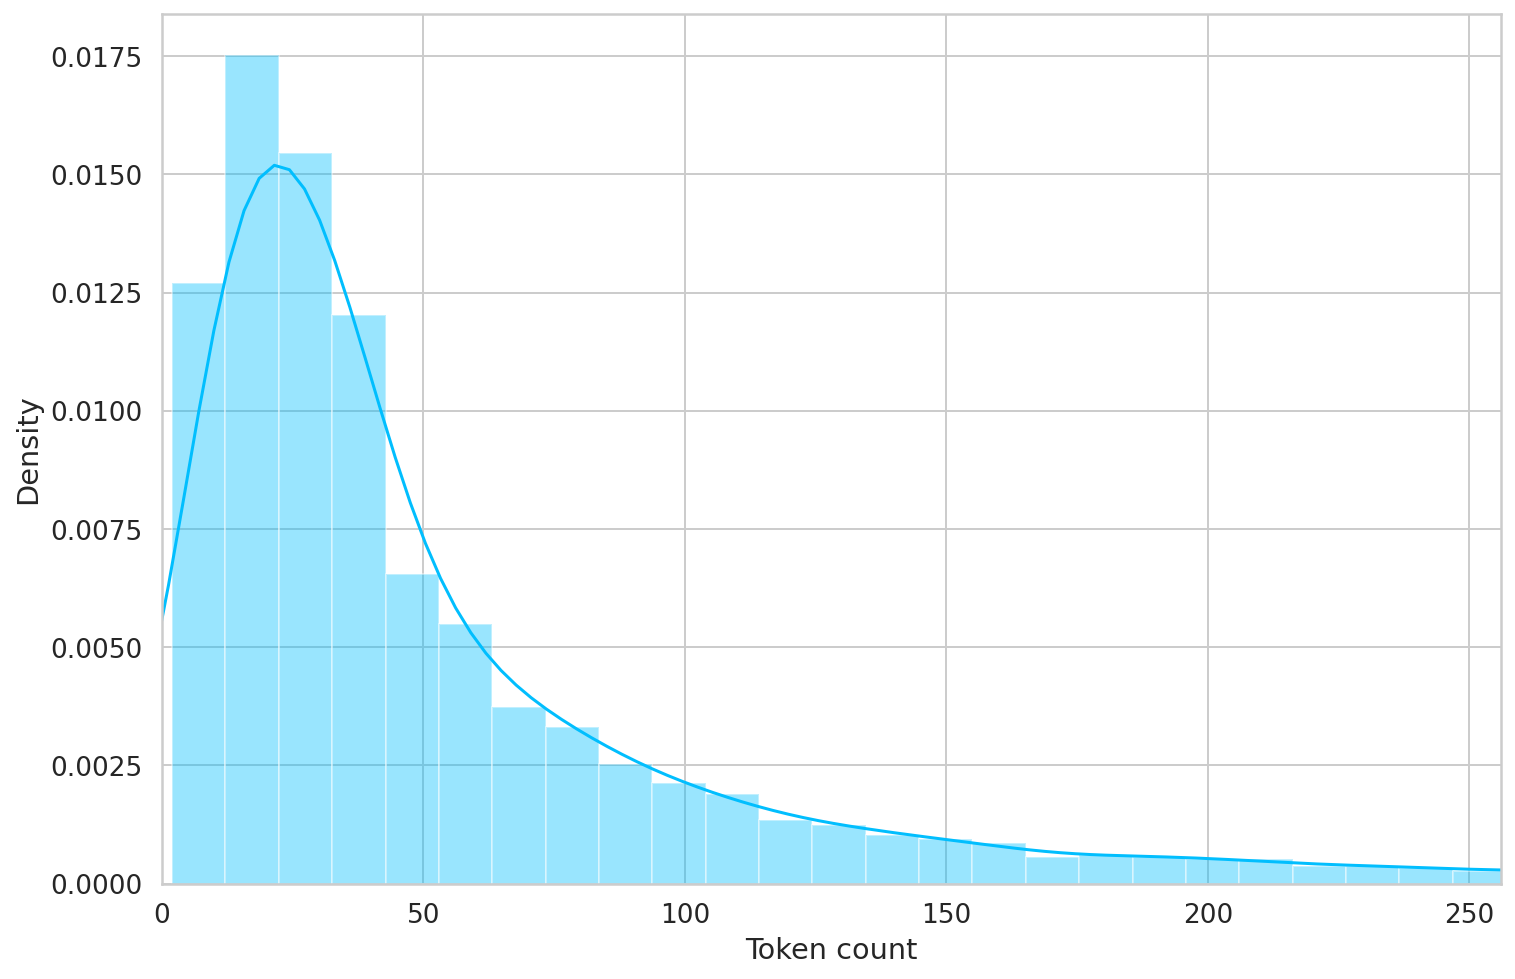

In [23]:
# plotting token length
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [24]:
# defining maximum lenght of sentence
MAX_LEN = 150

In [25]:
# creating dataset for training
class CustomDataset(Dataset):

  def __init__(self, text, labels, tokenizer, max_len):
    self.text = text
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    text = str(self.text[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding= 'max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation= True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'true_label': torch.tensor(label, dtype=torch.long)
    }

In [26]:
# calculating parameters for the sentence
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [27]:
# defining data loader function
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = CustomDataset(
    text=df4.Text.to_numpy(),
    labels=df4.oh_label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=16
  )

In [28]:
# creating train, test and validation data required for model
BATCH_SIZE = 64

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [29]:
# loading roberta model
roberta_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
# defining model architecture
class MyClassifier(nn.Module):

  def __init__(self, n_classes):
    super(MyClassifier, self).__init__()
    self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.roberta(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [31]:
# specifiying number of classed and pushing model to gpu
model = MyClassifier(2)
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
# defining hyperparameter of the model
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [33]:
# defining train function
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()
  loss_avg = AverageMeter()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["true_label"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    t = targets.float().view(-1,1) #[32,1]
    
    loss = loss_fn(outputs[:, 0:2], t[:, 0].long())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    loss_avg.update(loss.item(), targets.shape[0])

  return loss_avg.avg

In [34]:
# defining evaluation function
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  loss_avg = AverageMeter()
  o_   = torch.tensor([]).to(device) #use for metrics
  t_   = torch.tensor([]).to(device)

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["true_label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      t = targets.float().view(-1,1) #[256,1] batch size
      loss = loss_fn(outputs[:, 0:2], t[:, 0].long())

      # EVALUATE
      max_o = torch.argmax(outputs[:, 0:2], dim=1).view(-1,1)
      max_o = max_o.detach()
      o_    = torch.cat((o_, max_o)  , 0) #float and append
      t_    = torch.cat((t_, targets), 0)
      loss_avg.update(loss.item(), targets.shape[0])

    o_ = o_.cpu().numpy()
    t_ = t_.view(-1,1)# change shape same as o_
    t_ = t_.cpu().numpy()
    fscore = f1_score(t_[:, 0], o_[:, 0])
    accuracy= accuracy_score(t_[:, 0], o_[:, 0])

    return loss_avg.avg, [fscore, accuracy]

In [ ]:
%%time
# defining model evaluation metrices and training the model
train_loss_arr = []
val_loss_arr = []
val_metrics = [] #[f1 , accuracy]

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )
  print("Training Loss : ", train_loss)
  
  val_loss, metrics = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print("Validation Loss : ", val_loss)
  train_loss_arr.append(train_loss)
  val_loss_arr.append(val_loss)
  val_metrics.append(metrics)

Epoch 1/5
----------
Training Loss :  0.04819770762541277
Validation Loss :  5.75250912208355
Epoch 2/5
----------
Training Loss :  0.136102236518327
Validation Loss :  4.890644803945938
Epoch 3/5
----------
Training Loss :  0.17469917798544415
Validation Loss :  4.955983544823753
Epoch 4/5
----------
Training Loss :  0.23216729645591355
Validation Loss :  4.265548304811329
Epoch 5/5
----------


In [4]:
# evaluating model
test_loss, test_metrics = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_loss, test_metrics[0], test_metrics[1], test_metrics[2], test_metrics[3] = test_loss, f1, acc, prec, rec

In [5]:
# prininting model results
print("test Loss : ", )
print("test F1-Score : ", test_metrics[0])
print("test Accuracy Score : ", test_metrics[1])
print("test Precision value: ", test_metrics[2])
print("test Recall value : ", test_metrics[3])

test Loss : 
test F1-Score :  0.881
test Accuracy Score :  0.899
test Precision value:  0.875
test Recall value :  0.879
